In [1]:
# =============================================================================
# Cell 1: Imports and Setup
# =============================================================================
import torch
import torch.nn as nn
from torch.optim import Adam, AdamW
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
from torch.cuda.amp import GradScaler, autocast

# --- Import our custom modules ---
import sys
sys.path.append('../')
from src.data_loader import get_data_loaders
from src.models import UNet
from src.loss import DiceLoss
from torch.optim.lr_scheduler import ReduceLROnPlateau, CosineAnnealingWarmRestarts

# --- Configuration ---
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
LEARNING_RATE = 1e-3  # Increased from 1e-4
BATCH_SIZE = 16  # Increased from 8 (adjust based on your GPU memory)
IMAGE_SIZE = (256, 256)
NUM_EPOCHS = 50  # Increased epochs
NUM_WORKERS = 4  # Increased workers
DATA_PATH = '../data/CASIA2'
WEIGHT_DECAY = 1e-5  # Add L2 regularization

print(f"Using device: {DEVICE}")
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    torch.backends.cudnn.benchmark = True  # Speed up training

Using device: cuda


In [2]:
# =============================================================================
# Cell 2: Load Data
# =============================================================================

train_loader, val_loader, test_loader = get_data_loaders(
    root_dir=DATA_PATH,
    batch_size=BATCH_SIZE,
    image_size=IMAGE_SIZE,
    num_workers=NUM_WORKERS
)

print(f"\nData loaded successfully.")
print(f"{len(train_loader)} batches in the training loader.")
print(f"{len(val_loader)} batches in the validation loader.")

Found 4981 matching image-mask pairs.
Found 4981 matching image-mask pairs.
Found 4981 matching image-mask pairs.

Dataset Split:
  Training set size: 3586
  Validation set size: 897
  Test set size: 498
  Total: 4981

Data loaded successfully.
224 batches in the training loader.
57 batches in the validation loader.


In [3]:
# =============================================================================
# Cell 3: Initialize Model, Loss, and Optimizer
# =============================================================================

model = UNet(n_channels=3, n_classes=1, dropout=0.1).to(DEVICE)

# Loss Function with weighted combination
bce_loss = nn.BCEWithLogitsLoss()
dice_loss = DiceLoss()

# Use AdamW instead of Adam (better weight decay handling)
optimizer = AdamW(
    model.parameters(), 
    lr=LEARNING_RATE,
    weight_decay=WEIGHT_DECAY,
    betas=(0.9, 0.999)
)

# Better Learning Rate Scheduler - reduces LR when validation loss plateaus
scheduler = ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.5,  # Reduce by 50% (less aggressive)
    patience=5,  # Wait 5 epochs before reducing
    verbose=True,
    min_lr=1e-7
)

# Alternative: Cosine Annealing with Warm Restarts
# scheduler = CosineAnnealingWarmRestarts(
#     optimizer,
#     T_0=10,  # Restart every 10 epochs
#     T_mult=2,
#     eta_min=1e-6
# )

c:\Users\malek\anaconda3\envs\forgery_gpu\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [4]:
# =============================================================================
# Cell 4: Improved Training Loop with Mixed Precision
# =============================================================================

# Mixed precision training for faster computation
scaler = GradScaler() if DEVICE == "cuda" else None

# Lists to store metrics
train_losses = []
val_losses = []
learning_rates = []
best_val_loss = float('inf')

# Early stopping parameters
patience_counter = 0
early_stop_patience = 15

print("Starting training...")

for epoch in range(NUM_EPOCHS):
    model.train()
    
    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS}")
    
    epoch_train_loss = 0.0
    epoch_bce_loss = 0.0
    epoch_dice_loss = 0.0

    for batch_idx, (data, targets) in enumerate(loop):
        data = data.to(device=DEVICE)
        targets = targets.to(device=DEVICE)
        
        optimizer.zero_grad(set_to_none=True)  # More efficient than zero_grad()
        
        # Mixed precision training
        if scaler is not None:
            with torch.autocast(device_type=DEVICE):
                predictions = model(data)
                
                # Weighted loss combination (tune these weights)
                loss_b = bce_loss(predictions, targets)
                loss_d = dice_loss(predictions, targets)
                loss = 0.5 * loss_b + 0.5 * loss_d  # Equal weighting
            
            scaler.scale(loss).backward()
            
            # Gradient clipping to prevent exploding gradients
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            scaler.step(optimizer)
            scaler.update()
        else:
            predictions = model(data)
            loss_b = bce_loss(predictions, targets)
            loss_d = dice_loss(predictions, targets)
            loss = 0.5 * loss_b + 0.5 * loss_d
            
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
        
        epoch_train_loss += loss.item()
        epoch_bce_loss += loss_b.item()
        epoch_dice_loss += loss_d.item()
        
        loop.set_postfix(
            loss=loss.item(),
            bce=loss_b.item(),
            dice=loss_d.item(),
            lr=optimizer.param_groups[0]['lr']
        )

    # --- Validation Phase ---
    model.eval()
    epoch_val_loss = 0.0
    epoch_val_bce = 0.0
    epoch_val_dice = 0.0
    
    with torch.no_grad():
        for data, targets in val_loader:
            data = data.to(device=DEVICE)
            targets = targets.to(device=DEVICE)
            
            if scaler is not None:
                with torch.autocast(device_type=DEVICE):
                    predictions = model(data)
                    val_loss_b = bce_loss(predictions, targets)
                    val_loss_d = dice_loss(predictions, targets)
                    val_loss = 0.5 * val_loss_b + 0.5 * val_loss_d
            else:
                predictions = model(data)
                val_loss_b = bce_loss(predictions, targets)
                val_loss_d = dice_loss(predictions, targets)
                val_loss = 0.5 * val_loss_b + 0.5 * val_loss_d
            
            epoch_val_loss += val_loss.item()
            epoch_val_bce += val_loss_b.item()
            epoch_val_dice += val_loss_d.item()
    
    # Calculate average losses
    avg_train_loss = epoch_train_loss / len(train_loader)
    avg_val_loss = epoch_val_loss / len(val_loader)
    avg_train_bce = epoch_bce_loss / len(train_loader)
    avg_train_dice = epoch_dice_loss / len(train_loader)
    avg_val_bce = epoch_val_bce / len(val_loader)
    avg_val_dice = epoch_val_dice / len(val_loader)
    
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    learning_rates.append(optimizer.param_groups[0]['lr'])

    print(f"\nEpoch {epoch+1}/{NUM_EPOCHS}")
    print(f"Train -> Loss: {avg_train_loss:.4f}, BCE: {avg_train_bce:.4f}, Dice: {avg_train_dice:.4f}")
    print(f"Val   -> Loss: {avg_val_loss:.4f}, BCE: {avg_val_bce:.4f}, Dice: {avg_val_dice:.4f}")
    print(f"Learning Rate: {optimizer.param_groups[0]['lr']:.2e}")

    # Learning rate scheduling
    scheduler.step(avg_val_loss)  # For ReduceLROnPlateau
    # scheduler.step()  # For CosineAnnealingWarmRestarts
    
    # Save best model
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_loss': avg_val_loss,
        }, 'best_model.pth')
        print(f"✓ Best model saved! Val Loss: {best_val_loss:.4f}")
        patience_counter = 0
    else:
        patience_counter += 1
    
    # Early stopping
    if patience_counter >= early_stop_patience:
        print(f"\nEarly stopping triggered after {epoch+1} epochs")
        break

print("\nTraining finished!")

C:\Users\malek\AppData\Local\Temp\ipykernel_36832\768847268.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler() if DEVICE == "cuda" else None


Starting training...


Epoch 1/50: 100%|██████████| 224/224 [00:46<00:00,  4.78it/s, bce=0.406, dice=0.867, loss=0.637, lr=0.001]



Epoch 1/50
Train -> Loss: 0.5980, BCE: 0.3404, Dice: 0.8556
Val   -> Loss: 0.5821, BCE: 0.3290, Dice: 0.8352
Learning Rate: 1.00e-03
✓ Best model saved! Val Loss: 0.5821


Epoch 2/50: 100%|██████████| 224/224 [00:34<00:00,  6.44it/s, bce=0.356, dice=0.839, loss=0.597, lr=0.001]



Epoch 2/50
Train -> Loss: 0.5874, BCE: 0.3235, Dice: 0.8512
Val   -> Loss: 0.5807, BCE: 0.3273, Dice: 0.8342
Learning Rate: 1.00e-03
✓ Best model saved! Val Loss: 0.5807


Epoch 3/50: 100%|██████████| 224/224 [00:34<00:00,  6.49it/s, bce=0.411, dice=0.746, loss=0.579, lr=0.001]



Epoch 3/50
Train -> Loss: 0.5871, BCE: 0.3201, Dice: 0.8542
Val   -> Loss: 0.5821, BCE: 0.3359, Dice: 0.8283
Learning Rate: 1.00e-03


Epoch 4/50: 100%|██████████| 224/224 [00:36<00:00,  6.17it/s, bce=0.42, dice=0.854, loss=0.637, lr=0.001] 



Epoch 4/50
Train -> Loss: 0.5859, BCE: 0.3230, Dice: 0.8487
Val   -> Loss: 0.5795, BCE: 0.3406, Dice: 0.8185
Learning Rate: 1.00e-03
✓ Best model saved! Val Loss: 0.5795


Epoch 5/50: 100%|██████████| 224/224 [00:39<00:00,  5.65it/s, bce=0.285, dice=0.883, loss=0.584, lr=0.001]



Epoch 5/50
Train -> Loss: 0.5849, BCE: 0.3211, Dice: 0.8487
Val   -> Loss: 0.5784, BCE: 0.3254, Dice: 0.8314
Learning Rate: 1.00e-03
✓ Best model saved! Val Loss: 0.5784


Epoch 6/50: 100%|██████████| 224/224 [00:36<00:00,  6.06it/s, bce=0.441, dice=0.83, loss=0.636, lr=0.001] 



Epoch 6/50
Train -> Loss: 0.5817, BCE: 0.3202, Dice: 0.8432
Val   -> Loss: 0.5825, BCE: 0.3340, Dice: 0.8310
Learning Rate: 1.00e-03


Epoch 7/50: 100%|██████████| 224/224 [00:38<00:00,  5.75it/s, bce=0.295, dice=0.895, loss=0.595, lr=0.001]



Epoch 7/50
Train -> Loss: 0.5868, BCE: 0.3208, Dice: 0.8529
Val   -> Loss: 0.5799, BCE: 0.3279, Dice: 0.8318
Learning Rate: 1.00e-03


Epoch 8/50: 100%|██████████| 224/224 [00:34<00:00,  6.53it/s, bce=0.19, dice=0.797, loss=0.494, lr=0.001] 



Epoch 8/50
Train -> Loss: 0.5822, BCE: 0.3191, Dice: 0.8453
Val   -> Loss: 0.5796, BCE: 0.3329, Dice: 0.8262
Learning Rate: 1.00e-03


Epoch 9/50: 100%|██████████| 224/224 [00:34<00:00,  6.46it/s, bce=0.219, dice=0.968, loss=0.593, lr=0.001]



Epoch 9/50
Train -> Loss: 0.5813, BCE: 0.3208, Dice: 0.8418
Val   -> Loss: 0.5797, BCE: 0.3454, Dice: 0.8140
Learning Rate: 1.00e-03


Epoch 10/50: 100%|██████████| 224/224 [00:37<00:00,  5.91it/s, bce=0.473, dice=0.89, loss=0.681, lr=0.001] 



Epoch 10/50
Train -> Loss: 0.5845, BCE: 0.3191, Dice: 0.8499
Val   -> Loss: 0.5777, BCE: 0.3441, Dice: 0.8112
Learning Rate: 1.00e-03
✓ Best model saved! Val Loss: 0.5777


Epoch 11/50: 100%|██████████| 224/224 [00:31<00:00,  7.17it/s, bce=0.282, dice=0.709, loss=0.495, lr=0.001]



Epoch 11/50
Train -> Loss: 0.5804, BCE: 0.3207, Dice: 0.8402
Val   -> Loss: 0.5796, BCE: 0.3384, Dice: 0.8208
Learning Rate: 1.00e-03


Epoch 12/50: 100%|██████████| 224/224 [00:30<00:00,  7.46it/s, bce=0.442, dice=0.879, loss=0.661, lr=0.001]



Epoch 12/50
Train -> Loss: 0.5816, BCE: 0.3211, Dice: 0.8422
Val   -> Loss: 0.5759, BCE: 0.3326, Dice: 0.8191
Learning Rate: 1.00e-03
✓ Best model saved! Val Loss: 0.5759


Epoch 13/50: 100%|██████████| 224/224 [00:30<00:00,  7.33it/s, bce=0.227, dice=0.795, loss=0.511, lr=0.001]



Epoch 13/50
Train -> Loss: 0.5814, BCE: 0.3182, Dice: 0.8446
Val   -> Loss: 0.5759, BCE: 0.3413, Dice: 0.8105
Learning Rate: 1.00e-03


Epoch 14/50: 100%|██████████| 224/224 [00:33<00:00,  6.64it/s, bce=0.257, dice=0.935, loss=0.596, lr=0.001]



Epoch 14/50
Train -> Loss: 0.5846, BCE: 0.3200, Dice: 0.8492
Val   -> Loss: 0.5779, BCE: 0.3256, Dice: 0.8302
Learning Rate: 1.00e-03


Epoch 15/50: 100%|██████████| 224/224 [00:30<00:00,  7.36it/s, bce=0.338, dice=0.78, loss=0.559, lr=0.001] 



Epoch 15/50
Train -> Loss: 0.5839, BCE: 0.3198, Dice: 0.8480
Val   -> Loss: 0.5804, BCE: 0.3363, Dice: 0.8244
Learning Rate: 1.00e-03


Epoch 16/50: 100%|██████████| 224/224 [00:31<00:00,  7.15it/s, bce=0.354, dice=0.758, loss=0.556, lr=0.001]



Epoch 16/50
Train -> Loss: 0.5851, BCE: 0.3186, Dice: 0.8517
Val   -> Loss: 0.5813, BCE: 0.3349, Dice: 0.8277
Learning Rate: 1.00e-03


Epoch 17/50: 100%|██████████| 224/224 [00:33<00:00,  6.71it/s, bce=0.287, dice=0.886, loss=0.587, lr=0.001]



Epoch 17/50
Train -> Loss: 0.5824, BCE: 0.3182, Dice: 0.8467
Val   -> Loss: 0.5775, BCE: 0.3331, Dice: 0.8218
Learning Rate: 1.00e-03


Epoch 18/50: 100%|██████████| 224/224 [00:32<00:00,  6.87it/s, bce=0.338, dice=0.862, loss=0.6, lr=0.001]  



Epoch 18/50
Train -> Loss: 0.5834, BCE: 0.3186, Dice: 0.8483
Val   -> Loss: 0.5781, BCE: 0.3282, Dice: 0.8281
Learning Rate: 1.00e-03


Epoch 19/50: 100%|██████████| 224/224 [00:29<00:00,  7.60it/s, bce=0.436, dice=0.923, loss=0.68, lr=0.0005] 



Epoch 19/50
Train -> Loss: 0.5837, BCE: 0.3188, Dice: 0.8486
Val   -> Loss: 0.5739, BCE: 0.3253, Dice: 0.8224
Learning Rate: 5.00e-04
✓ Best model saved! Val Loss: 0.5739


Epoch 20/50: 100%|██████████| 224/224 [00:28<00:00,  7.80it/s, bce=0.348, dice=0.923, loss=0.635, lr=0.0005]



Epoch 20/50
Train -> Loss: 0.5819, BCE: 0.3167, Dice: 0.8471
Val   -> Loss: 0.5744, BCE: 0.3281, Dice: 0.8207
Learning Rate: 5.00e-04


Epoch 21/50: 100%|██████████| 224/224 [00:30<00:00,  7.35it/s, bce=0.347, dice=0.766, loss=0.557, lr=0.0005]



Epoch 21/50
Train -> Loss: 0.5827, BCE: 0.3200, Dice: 0.8454
Val   -> Loss: 0.5753, BCE: 0.3221, Dice: 0.8285
Learning Rate: 5.00e-04


Epoch 22/50: 100%|██████████| 224/224 [00:32<00:00,  6.94it/s, bce=0.247, dice=0.884, loss=0.565, lr=0.0005]



Epoch 22/50
Train -> Loss: 0.5821, BCE: 0.3183, Dice: 0.8458
Val   -> Loss: 0.5718, BCE: 0.3263, Dice: 0.8173
Learning Rate: 5.00e-04
✓ Best model saved! Val Loss: 0.5718


Epoch 23/50: 100%|██████████| 224/224 [00:28<00:00,  7.82it/s, bce=0.246, dice=0.641, loss=0.444, lr=0.0005]



Epoch 23/50
Train -> Loss: 0.5814, BCE: 0.3165, Dice: 0.8463
Val   -> Loss: 0.5714, BCE: 0.3329, Dice: 0.8100
Learning Rate: 5.00e-04
✓ Best model saved! Val Loss: 0.5714


Epoch 24/50: 100%|██████████| 224/224 [00:29<00:00,  7.69it/s, bce=0.292, dice=0.928, loss=0.61, lr=0.0005] 



Epoch 24/50
Train -> Loss: 0.5783, BCE: 0.3174, Dice: 0.8392
Val   -> Loss: 0.5721, BCE: 0.3324, Dice: 0.8119
Learning Rate: 5.00e-04


Epoch 25/50: 100%|██████████| 224/224 [00:33<00:00,  6.63it/s, bce=0.292, dice=0.787, loss=0.539, lr=0.0005]



Epoch 25/50
Train -> Loss: 0.5799, BCE: 0.3211, Dice: 0.8388
Val   -> Loss: 0.5708, BCE: 0.3287, Dice: 0.8130
Learning Rate: 5.00e-04
✓ Best model saved! Val Loss: 0.5708


Epoch 26/50: 100%|██████████| 224/224 [00:31<00:00,  7.15it/s, bce=0.36, dice=0.888, loss=0.624, lr=0.0005] 



Epoch 26/50
Train -> Loss: 0.5784, BCE: 0.3169, Dice: 0.8399
Val   -> Loss: 0.5701, BCE: 0.3285, Dice: 0.8117
Learning Rate: 5.00e-04
✓ Best model saved! Val Loss: 0.5701


Epoch 27/50: 100%|██████████| 224/224 [00:31<00:00,  7.17it/s, bce=0.313, dice=0.868, loss=0.59, lr=0.0005] 



Epoch 27/50
Train -> Loss: 0.5808, BCE: 0.3189, Dice: 0.8428
Val   -> Loss: 0.5723, BCE: 0.3320, Dice: 0.8127
Learning Rate: 5.00e-04


Epoch 28/50: 100%|██████████| 224/224 [00:30<00:00,  7.26it/s, bce=0.426, dice=0.85, loss=0.638, lr=0.0005] 



Epoch 28/50
Train -> Loss: 0.5769, BCE: 0.3171, Dice: 0.8367
Val   -> Loss: 0.5705, BCE: 0.3316, Dice: 0.8095
Learning Rate: 5.00e-04


Epoch 29/50: 100%|██████████| 224/224 [00:30<00:00,  7.24it/s, bce=0.269, dice=0.899, loss=0.584, lr=0.0005]



Epoch 29/50
Train -> Loss: 0.5773, BCE: 0.3182, Dice: 0.8364
Val   -> Loss: 0.5704, BCE: 0.3388, Dice: 0.8019
Learning Rate: 5.00e-04


Epoch 30/50: 100%|██████████| 224/224 [00:31<00:00,  7.22it/s, bce=0.445, dice=0.858, loss=0.651, lr=0.0005]



Epoch 30/50
Train -> Loss: 0.5771, BCE: 0.3182, Dice: 0.8360
Val   -> Loss: 0.5720, BCE: 0.3320, Dice: 0.8120
Learning Rate: 5.00e-04


Epoch 31/50: 100%|██████████| 224/224 [00:30<00:00,  7.24it/s, bce=0.27, dice=0.786, loss=0.528, lr=0.0005] 



Epoch 31/50
Train -> Loss: 0.5756, BCE: 0.3183, Dice: 0.8330
Val   -> Loss: 0.5699, BCE: 0.3272, Dice: 0.8127
Learning Rate: 5.00e-04
✓ Best model saved! Val Loss: 0.5699


Epoch 32/50: 100%|██████████| 224/224 [00:30<00:00,  7.26it/s, bce=0.314, dice=0.856, loss=0.585, lr=0.0005]



Epoch 32/50
Train -> Loss: 0.5783, BCE: 0.3185, Dice: 0.8381
Val   -> Loss: 0.5672, BCE: 0.3312, Dice: 0.8032
Learning Rate: 5.00e-04
✓ Best model saved! Val Loss: 0.5672


Epoch 33/50: 100%|██████████| 224/224 [00:31<00:00,  7.22it/s, bce=0.354, dice=0.86, loss=0.607, lr=0.0005] 



Epoch 33/50
Train -> Loss: 0.5764, BCE: 0.3199, Dice: 0.8329
Val   -> Loss: 0.5666, BCE: 0.3242, Dice: 0.8089
Learning Rate: 5.00e-04
✓ Best model saved! Val Loss: 0.5666


Epoch 34/50: 100%|██████████| 224/224 [00:30<00:00,  7.23it/s, bce=0.296, dice=0.654, loss=0.475, lr=0.0005]



Epoch 34/50
Train -> Loss: 0.5774, BCE: 0.3181, Dice: 0.8366
Val   -> Loss: 0.5640, BCE: 0.3250, Dice: 0.8030
Learning Rate: 5.00e-04
✓ Best model saved! Val Loss: 0.5640


Epoch 35/50: 100%|██████████| 224/224 [00:30<00:00,  7.28it/s, bce=0.372, dice=0.889, loss=0.63, lr=0.0005] 



Epoch 35/50
Train -> Loss: 0.5780, BCE: 0.3206, Dice: 0.8354
Val   -> Loss: 0.5721, BCE: 0.3279, Dice: 0.8162
Learning Rate: 5.00e-04


Epoch 36/50: 100%|██████████| 224/224 [00:31<00:00,  7.20it/s, bce=0.304, dice=0.925, loss=0.614, lr=0.0005]



Epoch 36/50
Train -> Loss: 0.5793, BCE: 0.3177, Dice: 0.8409
Val   -> Loss: 0.5691, BCE: 0.3306, Dice: 0.8076
Learning Rate: 5.00e-04


Epoch 37/50: 100%|██████████| 224/224 [00:30<00:00,  7.29it/s, bce=0.513, dice=0.78, loss=0.646, lr=0.0005] 



Epoch 37/50
Train -> Loss: 0.5727, BCE: 0.3147, Dice: 0.8307
Val   -> Loss: 0.5719, BCE: 0.3410, Dice: 0.8028
Learning Rate: 5.00e-04


Epoch 38/50: 100%|██████████| 224/224 [00:30<00:00,  7.29it/s, bce=0.244, dice=0.755, loss=0.5, lr=0.0005]  



Epoch 38/50
Train -> Loss: 0.5741, BCE: 0.3191, Dice: 0.8290
Val   -> Loss: 0.5671, BCE: 0.3320, Dice: 0.8022
Learning Rate: 5.00e-04


Epoch 39/50: 100%|██████████| 224/224 [00:31<00:00,  7.22it/s, bce=0.327, dice=0.89, loss=0.608, lr=0.0005] 



Epoch 39/50
Train -> Loss: 0.5751, BCE: 0.3163, Dice: 0.8339
Val   -> Loss: 0.5670, BCE: 0.3290, Dice: 0.8049
Learning Rate: 5.00e-04


Epoch 40/50: 100%|██████████| 224/224 [00:30<00:00,  7.25it/s, bce=0.398, dice=0.91, loss=0.654, lr=0.0005] 



Epoch 40/50
Train -> Loss: 0.5753, BCE: 0.3189, Dice: 0.8317
Val   -> Loss: 0.5640, BCE: 0.3243, Dice: 0.8036
Learning Rate: 5.00e-04
✓ Best model saved! Val Loss: 0.5640


Epoch 41/50: 100%|██████████| 224/224 [00:30<00:00,  7.25it/s, bce=0.281, dice=0.84, loss=0.561, lr=0.00025] 



Epoch 41/50
Train -> Loss: 0.5707, BCE: 0.3161, Dice: 0.8254
Val   -> Loss: 0.5638, BCE: 0.3344, Dice: 0.7932
Learning Rate: 2.50e-04
✓ Best model saved! Val Loss: 0.5638


Epoch 42/50: 100%|██████████| 224/224 [00:31<00:00,  7.22it/s, bce=0.279, dice=0.728, loss=0.503, lr=0.00025]



Epoch 42/50
Train -> Loss: 0.5695, BCE: 0.3158, Dice: 0.8232
Val   -> Loss: 0.5608, BCE: 0.3282, Dice: 0.7934
Learning Rate: 2.50e-04
✓ Best model saved! Val Loss: 0.5608


Epoch 43/50: 100%|██████████| 224/224 [00:30<00:00,  7.25it/s, bce=0.383, dice=0.8, loss=0.592, lr=0.00025]  



Epoch 43/50
Train -> Loss: 0.5700, BCE: 0.3152, Dice: 0.8249
Val   -> Loss: 0.5655, BCE: 0.3328, Dice: 0.7981
Learning Rate: 2.50e-04


Epoch 44/50: 100%|██████████| 224/224 [00:31<00:00,  7.22it/s, bce=0.299, dice=0.803, loss=0.551, lr=0.00025]



Epoch 44/50
Train -> Loss: 0.5730, BCE: 0.3202, Dice: 0.8259
Val   -> Loss: 0.5613, BCE: 0.3244, Dice: 0.7982
Learning Rate: 2.50e-04


Epoch 45/50: 100%|██████████| 224/224 [00:31<00:00,  7.15it/s, bce=0.339, dice=0.828, loss=0.583, lr=0.00025]



Epoch 45/50
Train -> Loss: 0.5706, BCE: 0.3158, Dice: 0.8254
Val   -> Loss: 0.5601, BCE: 0.3267, Dice: 0.7935
Learning Rate: 2.50e-04
✓ Best model saved! Val Loss: 0.5601


Epoch 46/50: 100%|██████████| 224/224 [00:31<00:00,  7.22it/s, bce=0.335, dice=0.808, loss=0.572, lr=0.00025]



Epoch 46/50
Train -> Loss: 0.5712, BCE: 0.3169, Dice: 0.8255
Val   -> Loss: 0.5591, BCE: 0.3242, Dice: 0.7939
Learning Rate: 2.50e-04
✓ Best model saved! Val Loss: 0.5591


Epoch 47/50: 100%|██████████| 224/224 [00:31<00:00,  7.06it/s, bce=0.303, dice=0.771, loss=0.537, lr=0.00025]



Epoch 47/50
Train -> Loss: 0.5740, BCE: 0.3185, Dice: 0.8294
Val   -> Loss: 0.5634, BCE: 0.3398, Dice: 0.7869
Learning Rate: 2.50e-04


Epoch 48/50: 100%|██████████| 224/224 [00:32<00:00,  6.84it/s, bce=0.365, dice=0.804, loss=0.584, lr=0.00025]



Epoch 48/50
Train -> Loss: 0.5743, BCE: 0.3185, Dice: 0.8300
Val   -> Loss: 0.5615, BCE: 0.3240, Dice: 0.7990
Learning Rate: 2.50e-04


Epoch 49/50: 100%|██████████| 224/224 [00:33<00:00,  6.72it/s, bce=0.258, dice=0.913, loss=0.586, lr=0.00025]



Epoch 49/50
Train -> Loss: 0.5727, BCE: 0.3162, Dice: 0.8293
Val   -> Loss: 0.5603, BCE: 0.3333, Dice: 0.7872
Learning Rate: 2.50e-04


Epoch 50/50: 100%|██████████| 224/224 [00:35<00:00,  6.27it/s, bce=0.259, dice=0.686, loss=0.473, lr=0.00025]



Epoch 50/50
Train -> Loss: 0.5704, BCE: 0.3160, Dice: 0.8248
Val   -> Loss: 0.5595, BCE: 0.3216, Dice: 0.7974
Learning Rate: 2.50e-04

Training finished!


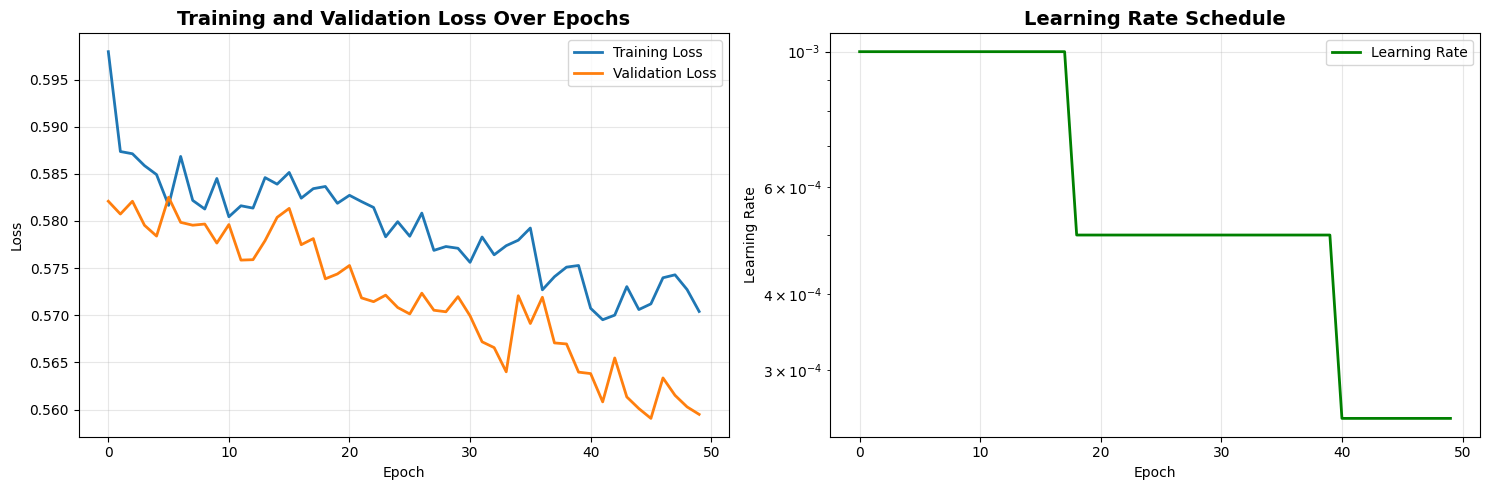

C:\Users\malek\AppData\Local\Temp\ipykernel_36832\1525993297.py:30: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('best_model.pth')
C:\Users\malek\Ap

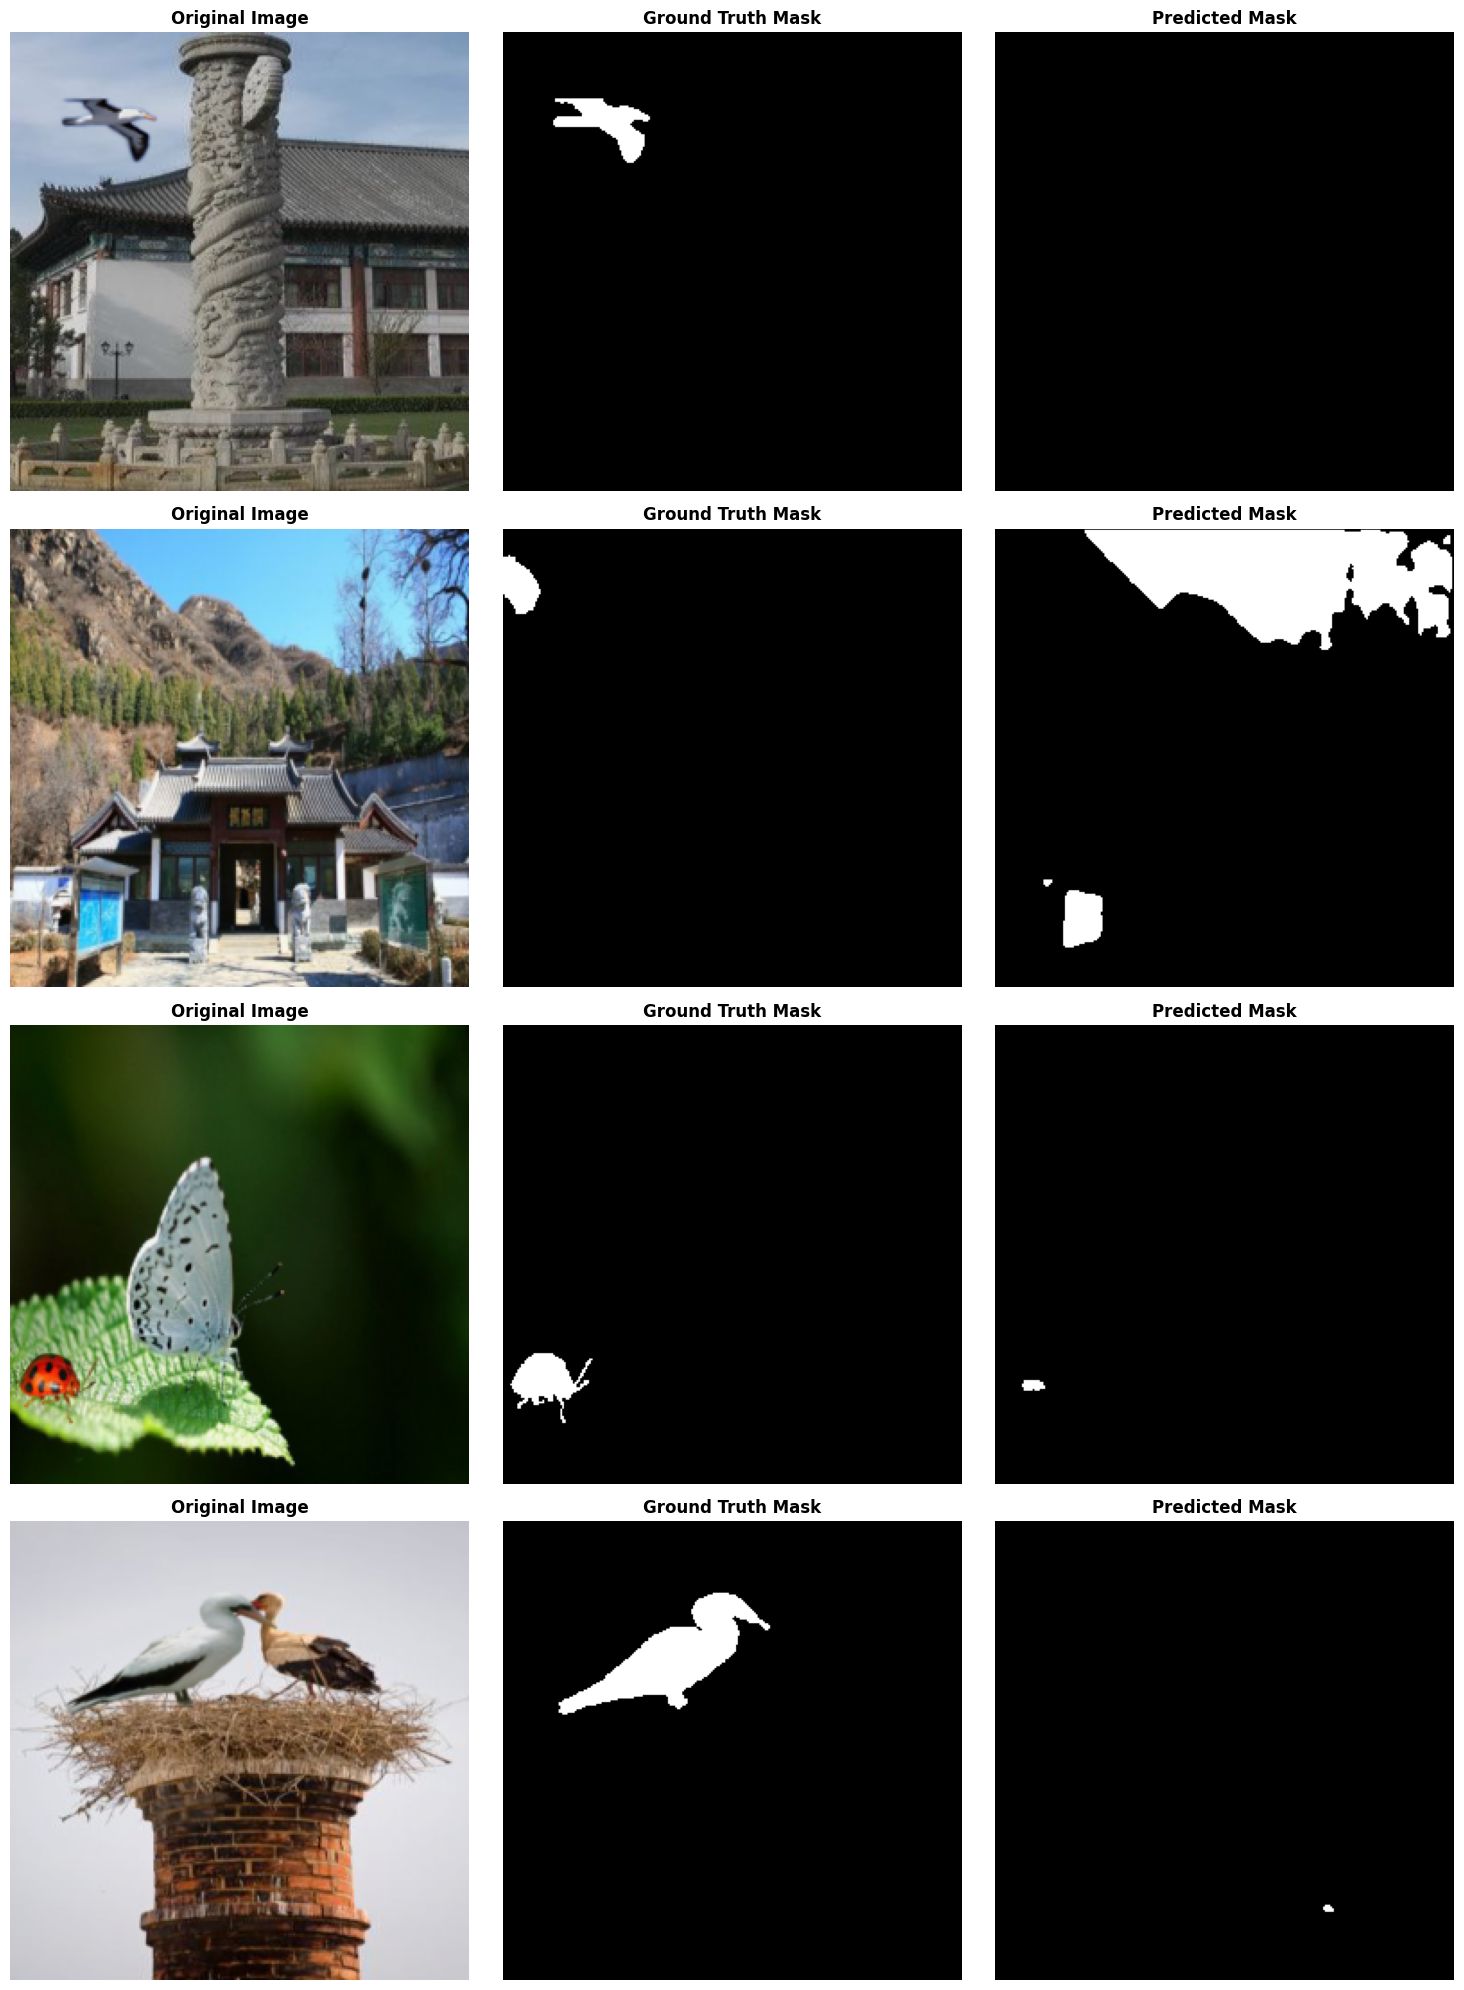

In [5]:
# =============================================================================
# Cell 5: Enhanced Visualization
# =============================================================================

# Plot training metrics
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Loss plot
axes[0].plot(train_losses, label='Training Loss', linewidth=2)
axes[0].plot(val_losses, label='Validation Loss', linewidth=2)
axes[0].set_title('Training and Validation Loss Over Epochs', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Learning rate plot
axes[1].plot(learning_rates, label='Learning Rate', color='green', linewidth=2)
axes[1].set_title('Learning Rate Schedule', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Learning Rate')
axes[1].set_yscale('log')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Load best model for visualization
checkpoint = torch.load('best_model.pth')
model.load_state_dict(checkpoint['model_state_dict'])

# Visualize predictions
model.eval()
with torch.no_grad():
    data, targets = next(iter(val_loader))
    data = data.to(DEVICE)
    
    if scaler is not None:
        with torch.cuda.amp.autocast():
            preds = torch.sigmoid(model(data)).cpu()
    else:
        preds = torch.sigmoid(model(data)).cpu()
    
    num_images_to_show = min(4, len(data))
    
    fig, axes = plt.subplots(num_images_to_show, 3, figsize=(15, 5 * num_images_to_show))
    
    for i in range(num_images_to_show):
        img = data[i].cpu().numpy().transpose((1, 2, 0))
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        img = std * img + mean
        img = np.clip(img, 0, 1)
        
        true_mask = targets[i].cpu().squeeze()
        pred_mask = (preds[i] > 0.5).float().squeeze()
        
        axes[i, 0].imshow(img)
        axes[i, 0].set_title("Original Image", fontweight='bold')
        axes[i, 0].axis('off')
        
        axes[i, 1].imshow(true_mask, cmap='gray')
        axes[i, 1].set_title("Ground Truth Mask", fontweight='bold')
        axes[i, 1].axis('off')

        axes[i, 2].imshow(pred_mask, cmap='gray')
        axes[i, 2].set_title("Predicted Mask", fontweight='bold')
        axes[i, 2].axis('off')

    plt.tight_layout()
    plt.show()